# Bird's eye view

In [1]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

For this notebook we're going to use calibrated images, for which we import the `CameraCalibration` class.

In [2]:
import sys
sys.path.append("..")

from pipeline import CameraCalibration

The `calibration.pkl` file is assumed to exist. If it doesn't, run the `calibrate_camera.py` script in the project's root directory.

In [3]:
cc = CameraCalibration.from_pickle(os.path.join('..', 'calibration.pkl'))

The images we're going to work with in this notebook can be found in the `test_images` directory.

In [4]:
image_paths = glob.glob(os.path.join('..', 'test_images', 'straight_lines*.jpg'))
image_paths

['../test_images/straight_lines1.jpg', '../test_images/straight_lines2.jpg']

Heres's one of the test images before calibration:

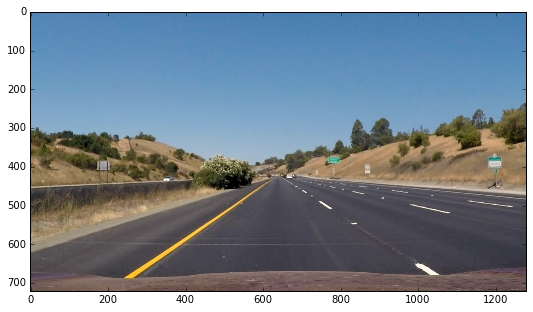

In [7]:
test_img_idx = 0
test_img = cv2.imread(image_paths[test_img_idx])
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
test_img_size = test_img.shape[1::-1]

plt.figure(figsize=(16, 5))
plt.imshow(test_img);

We can now undistort the image and obtain the region of interest.

In [8]:
test_undist, test_roi = cc.undistort(test_img)
test_roi

(45, 55, 1202, 621)

This is how the undistorted image looks like with the overlaid region of interest:

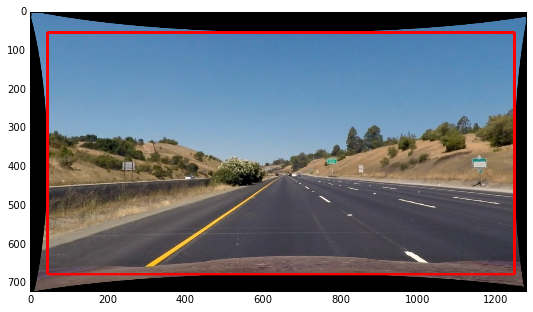

In [9]:
test_undist = cv2.rectangle(test_undist, 
                            test_roi[:2], (test_roi[0]+test_roi[2], test_roi[1]+test_roi[3]), 
                            color=(255, 0, 0), thickness=5)

plt.figure(figsize=(16, 5))
plt.imshow(test_undist);

Upon inspection of that image we do notice that we're likely going to crop into the image anyway, so we can directly discard all invalid pixels (at the minor sake of some valid pixels being dropped as well).

In [10]:
test_undist, test_roi = cc.undistort(test_img, False)
test_roi

(0, 0, 1280, 720)

Heres's the undistorted image where we're looking at only valid pixels.

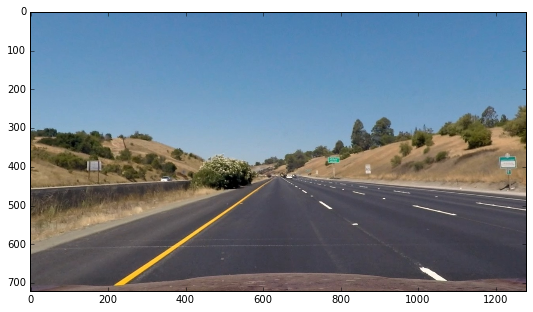

In [11]:
plt.figure(figsize=(16, 5))
plt.imshow(test_undist);

Our goal is to project the above image such that it appears as if the image was taken from directly 
above, rather than at an angle.

If we assume that the two lane lines are approximately straight, we can pick four points along them to define
a region in the image that can then be transformed (undistorted, really) to an orthogonal representation.

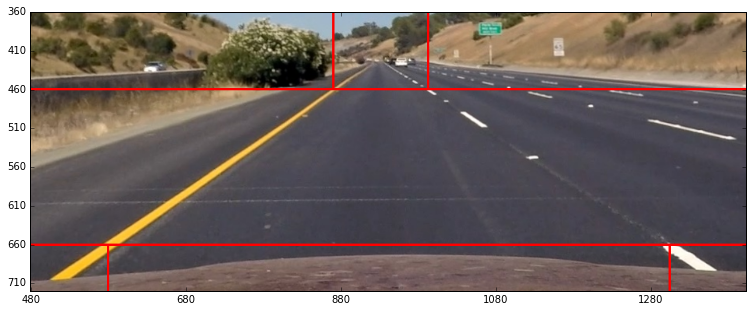

In [12]:
crop_marks = test_undist.copy()

# Empirically chosen coordinates
upper_y, lower_y = 460, 660
upper_left_x, upper_right_x = 580, 702
lower_left_x, lower_right_x = 290, 1013

def show_region(img, 
                upper_y=upper_y, lower_y=lower_y, lower_left_x=lower_left_x, lower_right_x=lower_right_x):
    offset = 100
    fig, ax = plt.subplots(figsize=(16, 5))
    plt.imshow(crop_marks[upper_y - offset:lower_y + offset, lower_left_x - offset:lower_right_x + offset])
    ax.set_yticklabels([str(int(y)) for y in ax.get_yticks() + upper_y - offset])
    ax.set_xticklabels([str(int(x)) for x in ax.get_xticks() + upper_left_x - offset]);

# Paint in the lines
color, thickness = (255, 0, 0), 2
h, w = crop_marks.shape[:2]
crop_marks = cv2.line(crop_marks, (0, upper_y), (w, upper_y), color, thickness)
crop_marks = cv2.line(crop_marks, (0, lower_y), (w, lower_y), color, thickness)
crop_marks = cv2.line(crop_marks, (lower_left_x, lower_y), (lower_left_x, h), color, thickness)
crop_marks = cv2.line(crop_marks, (lower_right_x, lower_y), (lower_right_x, h), color, thickness)
crop_marks = cv2.line(crop_marks, (upper_left_x, 0), (upper_left_x, upper_y), color, thickness)
crop_marks = cv2.line(crop_marks, (upper_right_x, 0), (upper_right_x, upper_y), color, thickness)
show_region(crop_marks)

In the end, we're going to look at this trapezoid:

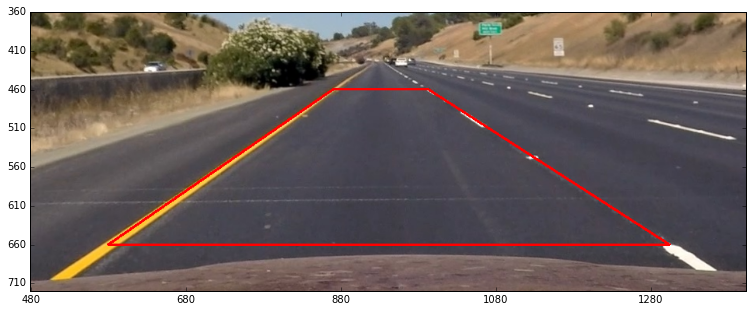

In [13]:
upper_left = [upper_left_x, upper_y]
upper_right = [upper_right_x, upper_y]
lower_left = [lower_left_x, lower_y]
lower_right = [lower_right_x, lower_y]

# Define the source trapezoid
src = np.array([upper_left, 
                upper_right, 
                lower_right, 
                lower_left])

# Paint the trapezoid
crop_marks = test_undist.copy()
crop_marks = cv2.polylines(crop_marks, [src], True, color, thickness)
show_region(crop_marks)

According to the Wikipedia article on [Interstate Highway standards](https://en.wikipedia.org/wiki/Interstate_Highway_standards), the U.S. Interstate Highway System uses a lane with of 12 feet, or about 3.66 meters. There is a cached website [640 Pavement Markin](https://webcache.googleusercontent.com/search?q=cache:JWZHPWSrU6oJ:https://www.dot.state.oh.us/Divisions/ConstructionMgt/OnlineDocs/Specifications/2008CMS/600/641.htm+&cd=1&hl=de&ct=clnk&gl=de) containing a section about the dimensions as well. From both sources, we are going to assume the following:

- The lane is 12 feet wide, or 3.6576 meters.
- The broken lines start every 40 feet, or 12.192 meters.
- Each dash is 10 feet long, or 2.048 meters, and
- Consequently, there is a 30 feet gap between dashes, or 9.144 meters.
- Finally, people _think_ the dashes are 2 feet long, [but obviously do underestimate the size dramatically](https://www.psychologicalscience.org/news/motr/lines-on-the-road-are-longer-than-you-think.html).

If these assumptions hold, the above trapezoid corresponds to a projected rectangle that is

- 3.6576 meters wide and
- 24.384 meters long (80 feet).

We are going to define one lane width to be 100 pixels and then laters expand our field of view one lane to the left and right.

In [50]:
# Define the destination trapezoid
segment_width = 3.6576
segment_height = 24.384

# Define a scale for meters to pixels
pixels_per_meter = 100./segment_width

dst = np.array([
    [segment_width, 0],
    [segment_width*2, 0], 
    [segment_width*2, segment_height],
    [segment_width, segment_height]
])

dst *= pixels_per_meter
dst

array([[ 100.        ,    0.        ],
       [ 200.        ,    0.        ],
       [ 200.        ,  666.66666667],
       [ 100.        ,  666.66666667]])

By this definition, we can easily convert from pixels to meters ...

In [51]:
100/pixels_per_lane

3.6576

... as well as the other way around:

In [52]:
meters_per_pixel = 1./pixels_per_lane
meters_per_pixel

0.036576

Given this, we'll find than 3.65 meters - a line width - is indeed 100 pixels in the image.

In [53]:
segment_width / meters_per_pixel

100.0

With the two give set of points, `src` and `dst`, a linear transformation can be obtained to undo the perspective transformation that was "observed" by the camera.

In [54]:
M = cv2.getPerspectiveTransform(src.astype(np.float32), dst.astype(np.float32))
M

array([[ -7.93461874e-02,  -3.53487265e-01,   1.98944696e+02],
       [ -1.09634524e-15,  -1.91224301e+00,   8.79631787e+02],
       [ -2.12097050e-18,  -2.38435293e-03,   1.00000000e+00]])

Using the matrix `M`, we can now unproject the camera image into a defined image space, were 100 pixels correspond to one lane width. We're also going to (emipircally) crop off the bottom of the image where the hood of the car would be.

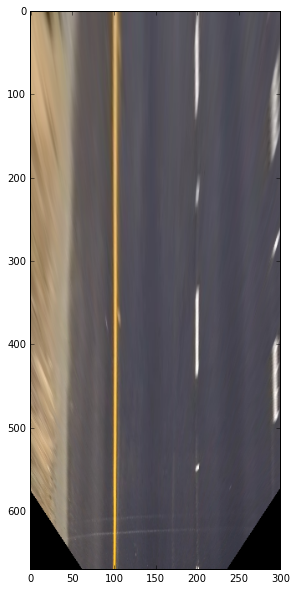

In [56]:
warped = cv2.warpPerspective(test_undist, M, (300, 670))

f, ax = plt.subplots(figsize=(20, 10))
ax.imshow(warped);